## Working with actual hurricane data

In [32]:
# importing everything

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline
import urllib.request
import rasterio

import shapely
from shapely.geometry import MultiPoint, MultiLineString, MultiPolygon, box

try:
  import contextily as ctx 
except:
  # install dependencies for contextily
  !apt install libproj-dev proj-data proj-bin
  !apt install libgeos-dev
  !pip install cython
  !pip install cartopy
  # install contextily
  !pip install contextily==1.0rc1 --no-use-pep517 --no-cache-dir
  import contextily as ctx
    
import networkx as nx
try:
  import osmnx as ox
except:
  # osmnx depends on the system package libspatialindex
  !apt install libspatialindex-dev
  !pip install osmnx
  import osmnx as ox

In [5]:
# setting up the figsize so that we don't have to keep entering it when plotting
plt.rcParams['figure.figsize'] = (20, 10)

In [6]:
post_hurricane_gpd = gpd.read_file('post-event-game-grid.geojson')

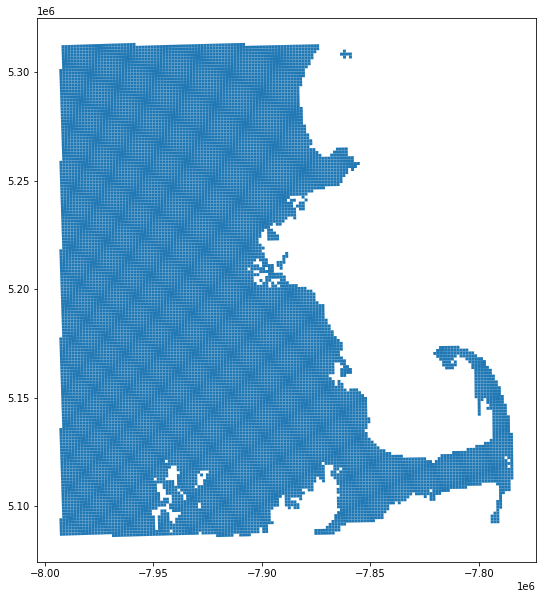

In [7]:
# visualizing the game grid
ax = post_hurricane_gpd.plot()

In [8]:
# view the columns of this dataframe
post_hurricane_gpd.head(1)

MGRS kmSQ_ID  GZD   EASTING   NORTHING MGRS_10km  Shape_Leng  \
0  19TBH7264      BH  19T  272000mE  4764000mN   19TBH76    0.042522   

   Shape_Le_1  Shape_Area  x_centroid  y_centroid  Health  Utility  Transport  \
0    0.042522     0.00011  -71.791007   42.999142       9        7          3   

   population     SVI                                           geometry  
0        15.0  0.2113  POLYGON ((-7991033.712 5311179.522, -7992397.7...

### DEMs

In [9]:
# bounds of the game grid

northernmost = post_hurricane_gpd['y_centroid'].max() + 0.1
southernmost = post_hurricane_gpd['y_centroid'].min() - 0.1
easternmost = post_hurricane_gpd['x_centroid'].max() + 0.1
westernmost = post_hurricane_gpd['x_centroid'].min() - 0.1
print(northernmost, southernmost, easternmost, westernmost)

43.105944652548644 41.40002700004018 -69.83111417229865 -71.89999370015873


In [10]:
# reading in the set of DEMs for the game grid

filepath = pd.read_csv('post-event-dems.csv')
filepath

sourceId        extent sourceOriginName  \
0  5deb32c9e4b02caea0f0ebbb  1 x 1 degree              gda   
1  5deb32c9e4b02caea0f0ebbd  1 x 1 degree              gda   
2  5deb32b8e4b02caea0f0eb4d  1 x 1 degree              gda   
3  5deb32b8e4b02caea0f0eb4f  1 x 1 degree              gda   
4  5deb32dbe4b02caea0f0ec2d  1 x 1 degree              gda   
5  5deb32b8e4b02caea0f0eb4b  1 x 1 degree              gda   
6  5deb32dbe4b02caea0f0ec2f  1 x 1 degree              gda   
7  5deb32dae4b02caea0f0ec2b  1 x 1 degree              gda   

                                         boundingBox  sizeInBytes  \
0  {minY:41.9994444436071,minX:-71.0005555562932,...    128354699   
1  {minY:41.9994444436071,minX:-72.0005555560934,...    489616162   
2  {minY:40.999444443807,minX:-71.0005555562932,m...    168352354   
3  {minY:40.999444443807,minX:-72.0005555560934,m...    301588789   
4  {minY:42.9994444434072,minX:-71.0005555562932,...    328027593   
5  {minY:40.999444443807,minX:-70.0005555564931,m...     18645141   
6  {minY:42.9994444448,minX:-72.0005555552,maxY:4...    468192000   
7  {minY:42.9994444443066,minX:-70.0005555555937,...     70323753   

   bestFitIndex   format                                        downloadURL  \
0      0.283969  GeoTIFF  https://prd-tnm.s3.amazonaws.com/StagedProduct...   
1      0.229785  GeoTIFF  https://prd-tnm.s3.amazonaws.com/StagedProduct...   
2      0.102182  GeoTIFF  https://prd-tnm.s3.amazonaws.com/StagedProduct...   
3      0.082685  GeoTIFF  https://prd-tnm.s3.amazonaws.com/StagedProduct...   
4      0.003214  GeoTIFF  https://prd-tnm.s3.amazonaws.com/StagedProduct...   
5      0.002927  GeoTIFF  https://prd-tnm.s3.amazonaws.com/StagedProduct...   
6      0.002601  GeoTIFF  https://prd-tnm.s3.amazonaws.com/StagedProduct...   
7      0.000092  GeoTIFF  https://prd-tnm.s3.amazonaws.com/StagedProduct...   

                                   previewGraphicURL prettyFileSize  \
0  https://prd-tnm.s3.amazonaws.com/StagedProduct...      122.41 MB   
1  https://prd-tnm.s3.amazonaws.com/StagedProduct...      466.93 MB   
2  https://prd-tnm.s3.amazonaws.com/StagedProduct...      160.55 MB   
3  https://prd-tnm.s3.amazonaws.com/StagedProduct...      287.62 MB   
4  https://prd-tnm.s3.amazonaws.com/StagedProduct...      312.83 MB   
5  https://prd-tnm.s3.amazonaws.com/StagedProduct...       17.78 MB   
6  https://prd-tnm.s3.amazonaws.com/StagedProduct...      446.50 MB   
7  https://prd-tnm.s3.amazonaws.com/StagedProduct...       67.07 MB   

                                            datasets  \
0  [National Elevation Dataset (NED) 1/3 arc-seco...   
1  [National Elevation Dataset (NED) 1/3 arc-seco...   
2  [National Elevation Dataset (NED) 1/3 arc-seco...   
3  [National Elevation Dataset (NED) 1/3 arc-seco...   
4  [National Elevation Dataset (NED) 1/3 arc-seco...   
5  [National Elevation Dataset (NED) 1/3 arc-seco...   
6  [National Elevation Dataset (NED) 1/3 arc-seco...   
7  [National Elevation Dataset (NED) 1/3 arc-seco...   

                                      title  sourceOriginId lastUpdated  \
0  USGS 1/3 arc-second n43w071 1 x 1 degree        14451005  2020-03-03   
1  USGS 1/3 arc-second n43w072 1 x 1 degree        14457431  2020-03-03   
2  USGS 1/3 arc-second n42w071 1 x 1 degree        14451007  2020-03-03   
3  USGS 1/3 arc-second n42w072 1 x 1 degree        14643650  2020-03-03   
4  USGS 1/3 arc-second n44w071 1 x 1 degree        14451006  2020-03-03   
5  USGS 1/3 arc-second n42w070 1 x 1 degree        14451008  2020-03-03   
6   USGS 13 arc-second n44w072 1 x 1 degree        14429478  2020-03-03   
7   USGS 13 arc-second n44w070 1 x 1 degree        14429271  2020-03-03   

  dateCreated                                            metaUrl   sourceName  \
0  2019-12-06  https://www.sciencebase.gov/catalog/item/5deb3...  ScienceBase   
1  2019-12-06  https://www.sciencebase.gov/catalog/item/5deb3...  ScienceBase   
2  2019-12-06  https://www.sciencebase.gov/catalog/item/5deb3.

In [11]:
# downloading each DEM

for idx, path in enumerate(filepath['downloadURL']):
    urllib.request.urlretrieve(path, 'post-event-images/dem-orig-{}.tif'.format(idx))
print('Done!')

FileNotFoundError: [Errno 2] No such file or directory: 'post-event-images/dem-orig-0.tif'

In [ ]:
# creating each elevation map from the DEMs

!/opt/conda/bin/gdaldem hillshade post-event-images/dem-orig-0.tif post-event-images/dem-hs-0.tif

!/opt/conda/bin/gdaldem hillshade post-event-images/dem-orig-1.tif post-event-images/dem-hs-1.tif

!/opt/conda/bin/gdaldem hillshade post-event-images/dem-orig-2.tif post-event-images/dem-hs-2.tif

!/opt/conda/bin/gdaldem hillshade post-event-images/dem-orig-3.tif post-event-images/dem-hs-3.tif

!/opt/conda/bin/gdaldem hillshade post-event-images/dem-orig-4.tif post-event-images/dem-hs-4.tif

!/opt/conda/bin/gdaldem hillshade post-event-images/dem-orig-5.tif post-event-images/dem-hs-5.tif

!/opt/conda/bin/gdaldem hillshade post-event-images/dem-orig-6.tif post-event-images/dem-hs-6.tif

!/opt/conda/bin/gdaldem hillshade post-event-images/dem-orig-7.tif post-event-images/dem-hs-7.tif

In [ ]:
# visualizing one of the elevation maps (sanity check)
# DOESN'T WORK

with rasterio.open('post-event-images/dem-hs-0.tif', 'r') as src:
    print(src.meta)
    hillshade = src.read(1)
    hillshade_mask = src.read_masks(1)
    hillshade_transform = src.profile['transform']
    
    fig, ax = plt.subplots(1,figsize = (10,10))
    
    rasterio.plot.show(np.ma.masked_where(hillshade_mask==0, hillshade), transform=hillshade_transform, ax=ax)
   
    plt.show() 

### OSM

In [28]:
file = pd.read_csv("http://ladi.s3-us-west-2.amazonaws.com/Labels/ladi_images_metadata.csv")

In [23]:
hurricane_imgs = file.loc[(file['gps_lat'] < northernmost) & (file['gps_lat'] > southernmost) & (file['gps_lon'] > westernmost) &( file['gps_lon'] < easternmost)] 
hurricane_imgs.to_csv('hurricane_imgs.csv') 

In [27]:
gdf = gpd.GeoDataFrame(hurricane_imgs, geometry=gpd.points_from_xy(hurricane_imgs.gps_lon, hurricane_imgs.gps_lat))
gdf

/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


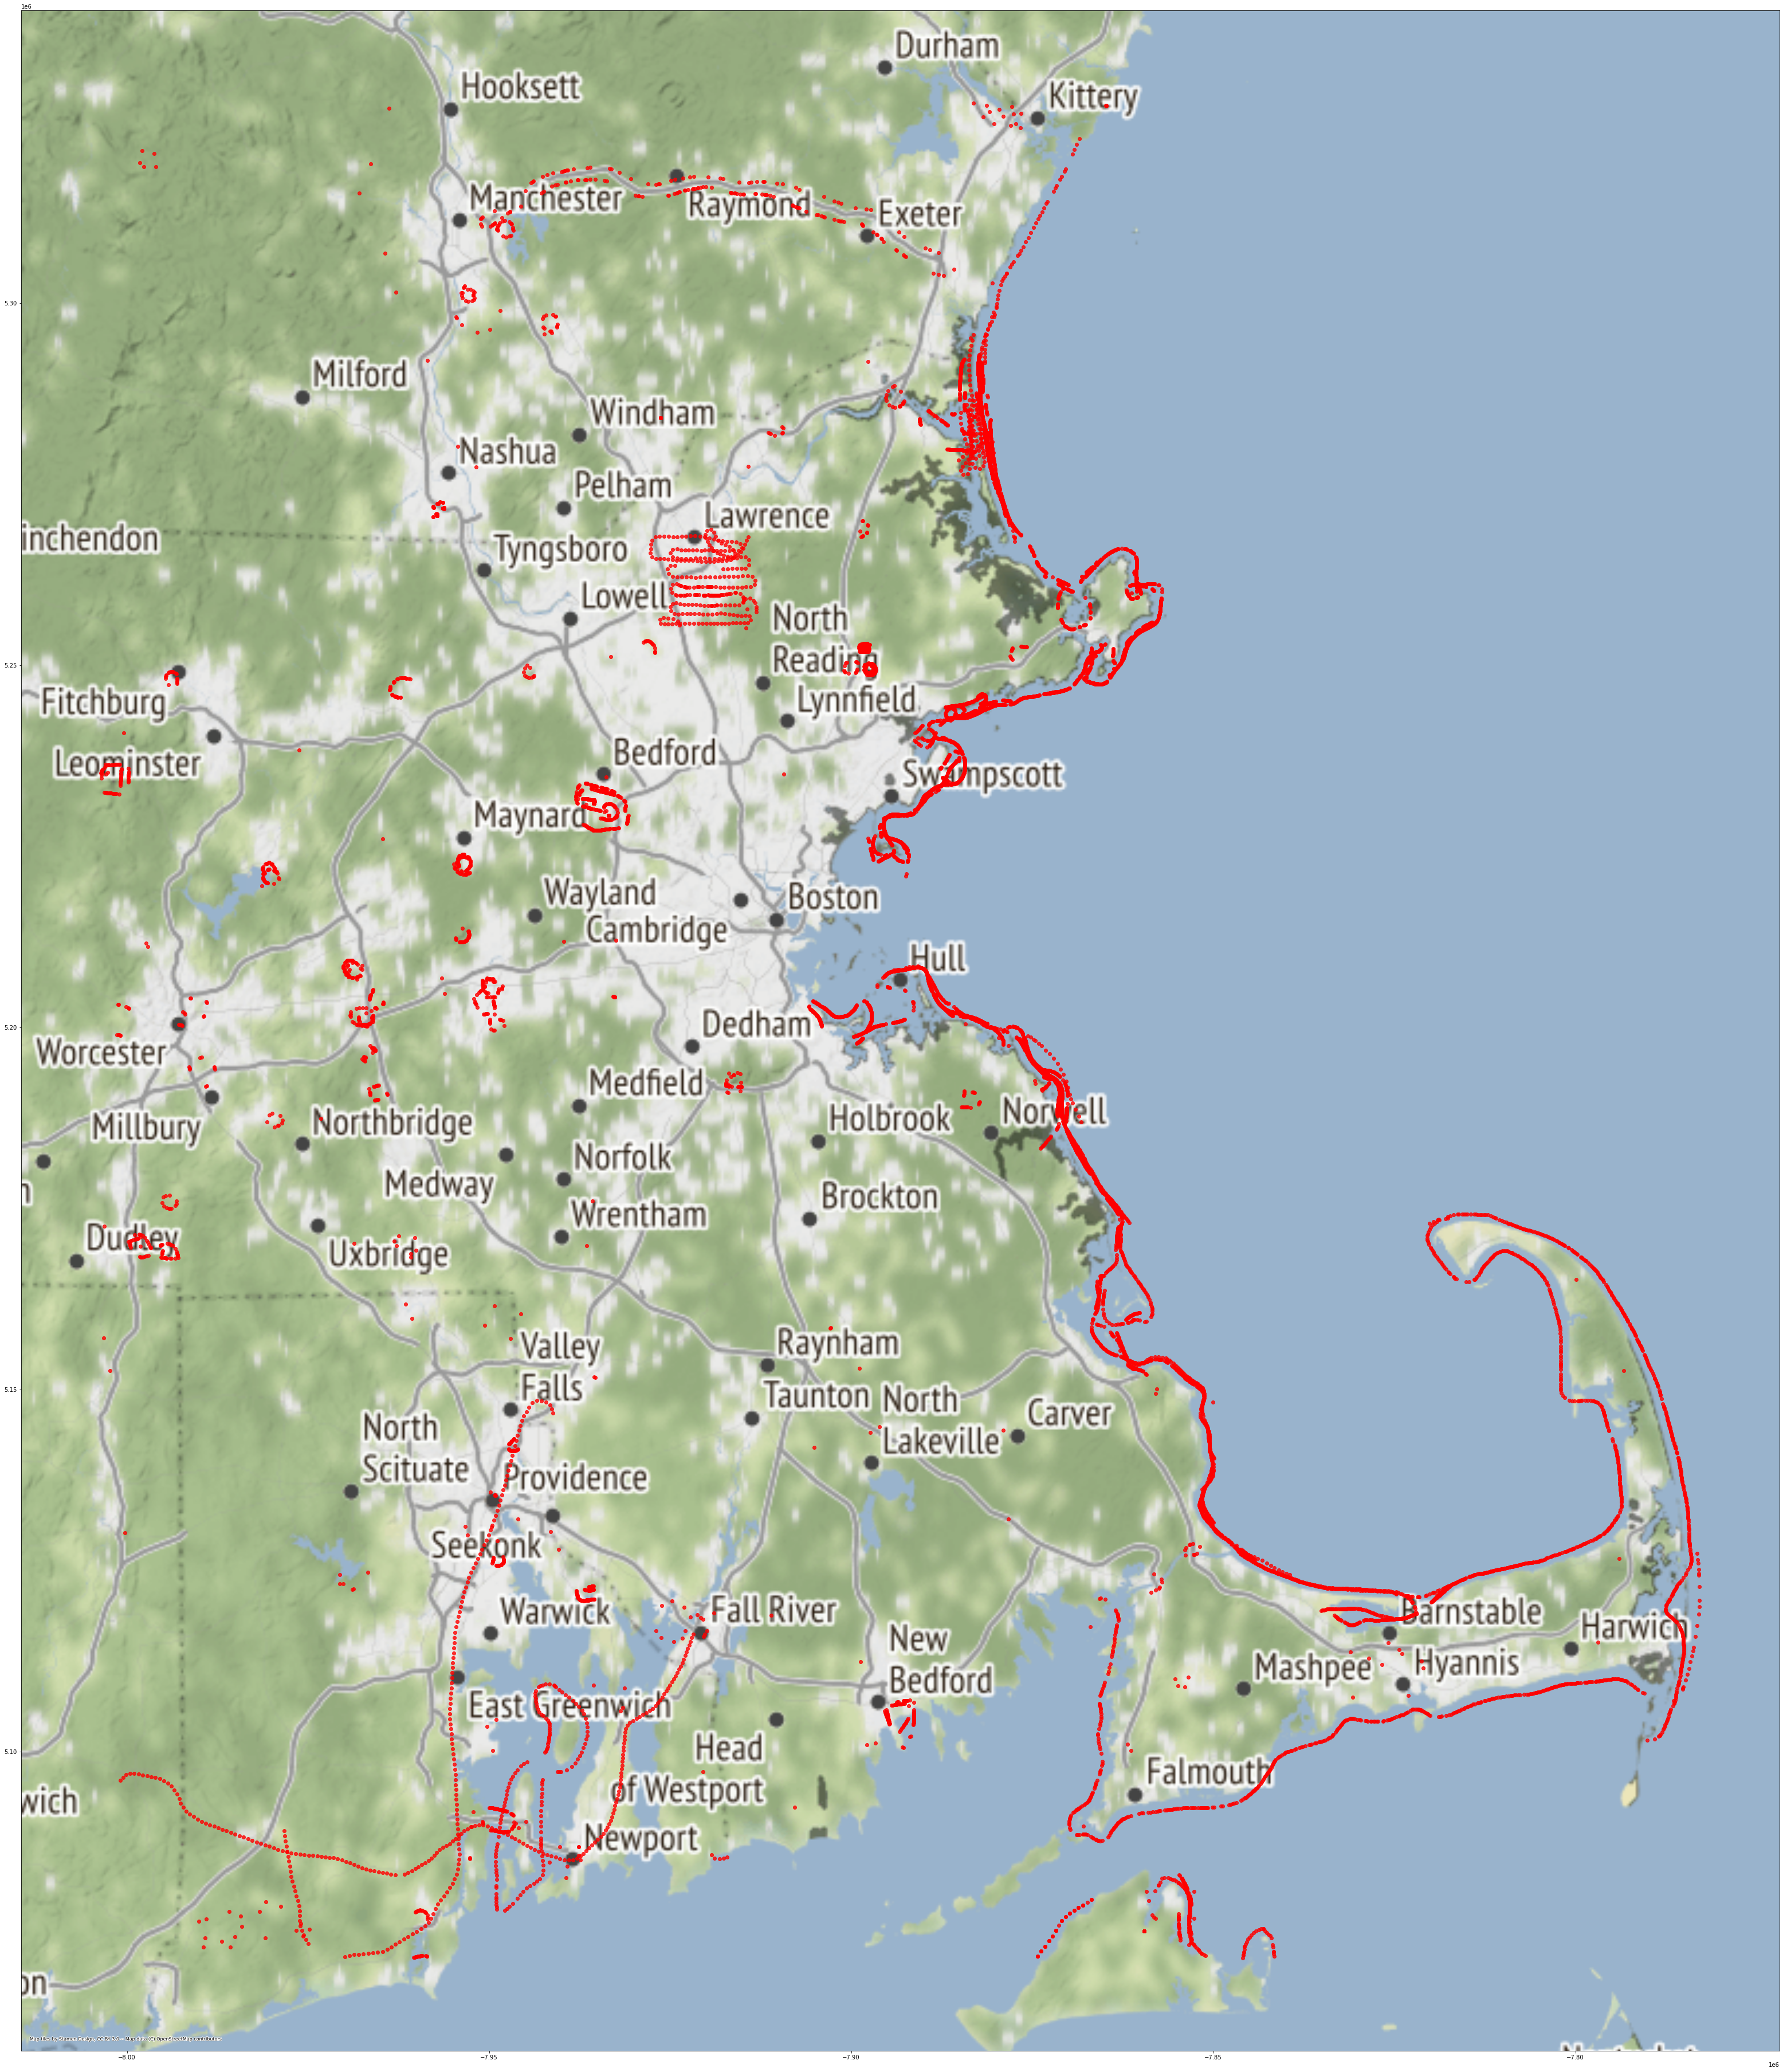

In [29]:
gdf.crs = {'init' :'epsg:4326'}
ax_coords = gdf.to_crs(epsg=3857).plot(figsize=(55, 350), alpha=.8, color='red')
ctx.add_basemap(ax_coords)

In [48]:
new_gdf = gpd.GeoDataFrame()
for index, row in gdf.iloc[40:60].iterrows():
    new_poly = row['geometry'].buffer(.1)
#     temp_gdf = ox.pois.pois_from_polygon(new_poly, tags = {'aeroway': True, 'building': 'yes'})
    temp_gdf = ox.pois.pois_from_polygon(new_poly, tags = {'amenity': 'hospital'})
    new_gdf = new_gdf.append(temp_gdf)


In [49]:
# gdf.crs = {'init' :'epsg:4326'}
# roads = ox.graph.graph_from_bbox(gdf['gps_lat'].max(), gdf['gps_lat'].min(), gdf['gps_lon'].max(), gdf['gps_lon'].min())
ax = new_gdf.to_crs(epsg=3857).plot(figsize=(55, 450), alpha=.8, color='blue', markersize = 100)
# gdf.to_crs(epsg=3857).plot(figsize=(10, 350), alpha=.8, color="blue", ax=ax)
ctx.add_basemap(ax)

AttributeError: No geometry data set yet (expected in column 'geometry'.)

In [ ]:
ax5 = gdf.plot(figsize=(100, 250))
# choose any of the supported maps from ctx.sources
ctx.add_basemap(ax5, url='http://tile.stamen.com/watercolor/tileZ/tileX/tileY.png')
ax.set_axis_off()
plt.show()

In [ ]:
fig1= plt.figure()

ax5 = gdf.plot(figsize=(100, 250))
ax8 = fig1.add_subplot()
# choose any of the supported maps from ctx.sources
ctx.add_basemap(ax5, url='http://tile.stamen.com/watercolor/tileZ/tileX/tileY.png')
new_gdf.to_crs(epsg=3857).plot(figsize=(10, 350), alpha=.8, color='blue', ax=ax5)
s
ax.set_axis_off()
plt.show()